In [260]:
# Setup Environment
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")

Version: 2.9.1+cu128, GPU: True, NUM_GPU: 1


In [261]:
# build tokenizer
import tokenizers
from tokenizers import normalizers
from tokenizers import pre_tokenizers
from tokenizers import trainers

import os

def process_files_for_tokenizer(files):
    temp_directory = "temp_files"
    os.makedirs(temp_directory, exist_ok=True)
    outfiles = []
    for file in files:
        outname = os.path.join(temp_directory, os.path.basename(file))
        with open(file, "r") as file_in, open(outname, "w") as file_out:
            raw_data = file_in.read()
            allocation_sites = raw_data.split("\n")
            for site in allocation_sites:
                elements = site.split(">|<")
                if len(elements) < 4:
                    continue
                new_content = "\n".join(elements[3:])
                file_out.write(new_content + "\n")
        outfiles.append(outname)
    return outfiles

def build_tokenizer(files):
    normalizer = normalizers.BertNormalizer()
    pre_tokenizer = pre_tokenizers.Split(tokenizers.Regex("::|,|\\(|\\)|\\n"), "isolated")
    tok_model = tokenizers.models.BPE(unk_token="[UNK]")
    tok_result = tokenizers.Tokenizer(tok_model)
    tok_result.normalizer = normalizer
    tok_result.pre_tokenizer = pre_tokenizer
    trainer = trainers.BpeTrainer(
        vocab_size=5000,
        min_frequency=2,
        special_tokens=["[UNK]"]
    )
    tok_result.train(process_files_for_tokenizer(files), trainer)
    tok_result.save("tokenizer.json")


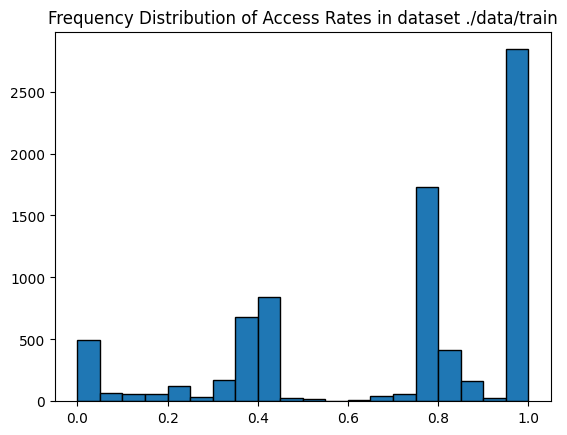

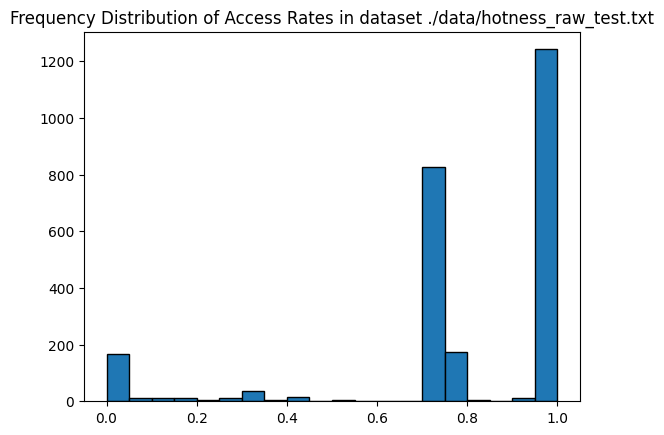

' for x, y in train_dataloader:\n    print(f"Shape of x: {x[0].shape}")\n    print(f"Shape of y: {y.shape}, {y.dtype}")\n '

<Figure size 640x480 with 0 Axes>

In [262]:
# Define Dataset
import random
import torch.utils.data
from torch.nn.utils.rnn import pad_sequence

batch_size = 32
thresh_low = 0.2
thresh_high = 0.8

# get list of files in data/train
train_dir = "./data/train"
train_files = os.listdir(train_dir)

try:
    tokenizer = tokenizers.Tokenizer.from_file("tokenizer.json")
except:
    build_tokenizer(train_files)
    tokenizer = tokenizers.Tokenizer.from_file("tokenizer.json")

class MemoryHotnessDataset(Dataset):
    def __init__(self, data_path, is_directory, transform=None):
        self.labels = []
        frequency_distribution = []
        all_data = ""
        if is_directory:
            for file in os.listdir(data_path):
                with open(f"{data_path}/{file}", "r") as data_file:
                    all_data += data_file.read() + "\n"
        else:
            with open(data_path, "r") as data_file:
                all_data = data_file.read()
        
        allocation_sites = all_data.split("\n")
        random.shuffle(allocation_sites)
        self.data_points = []
        for site in allocation_sites:
            elements = site.split(">|<", 3)
            if len(elements) < 4:
                # print(elements)
                continue
            average_size = torch.tensor([torch.log1p(torch.tensor([int(elements[0])]))]).type(torch.float32)
            if int(elements[1]) == 0:
                continue
            access_rate = int(elements[2]) / int(elements[1])
            frequency_distribution.append(access_rate)
            stack_trace = elements[3]
            symbols = tokenizer.encode(stack_trace).ids
            symbols = torch.tensor(symbols)
            category_idx = 0 if access_rate < thresh_low else (1 if access_rate < thresh_high else 2)
            self.labels.append(category_idx)
            # turn access_rate into a tensor
            category = torch.tensor([access_rate < thresh_low, access_rate >= thresh_low and access_rate < thresh_high, access_rate >= thresh_high]).type(torch.float32)
            # print(f"Symbols: {symbols}\nAverage size: {average_size}\nAccess: {access}")
            self.data_points.append(((symbols, average_size), category))
        # print("Snapshot of data: ", self.data_points[0])
        plt.hist(frequency_distribution, bins=20, edgecolor="black")
        plt.title(f"Frequency Distribution of Access Rates in dataset {data_path}")
        plt.show()
        plt.clf()
        self.labels = torch.tensor(self.labels)
            
    def __len__(self):
        return len(self.data_points)

    def __getitem__(self, idx):
        return self.data_points[idx][0], self.data_points[idx][1]

training_data = MemoryHotnessDataset("./data/train", True)
# Calculate class weights
class_counts = torch.bincount(training_data.labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in training_data.labels]

sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(training_data),
    replacement=True
)

def collate_fn(batch):
    """Pad variable-length sequences for batching."""
    tokens_list = [item[0][0] for item in batch]  # Get tokens from each sample
    sizes_list = [item[0][1] for item in batch]   # Get average_size from each sample
    labels_list = [item[1] for item in batch]     # Get labels
    
    # Pad sequences to the same length within the batch
    tokens_padded = pad_sequence(tokens_list, batch_first=True, padding_value=0)
    sizes = torch.stack(sizes_list)
    labels = torch.stack(labels_list)
    
    return (tokens_padded, sizes), labels


train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=sampler, collate_fn=collate_fn)

test_data = MemoryHotnessDataset("./data/hotness_raw_test.txt", False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)


""" for x, y in train_dataloader:
    print(f"Shape of x: {x[0].shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
 """

In [263]:
# Define Model

class HotnessPredictor(nn.Module):
    def __init__(self, embedding_dim=32, hidden_size=64, num_layers=1, num_categories=3):
        super().__init__()
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), embedding_dim=embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size + 1, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_categories)
        # NOTE: Don't use softmax here when using CrossEntropyLoss!
        # CrossEntropyLoss expects raw logits and applies log-softmax internally.
    
    def forward(self, tokens, average_size):
        out = self.embedding(tokens)
        _, out = self.gru(out) # shape (bidirectional * num_layers, batch_size, hidden_size)
        out = out.squeeze(0)
        #out = self.dropout(out)
        out = self.fc(torch.cat((out, average_size), dim=1))
        out = self.relu(out)
        out = self.fc2(out)
        # Return raw logits - apply softmax only during inference if you need probabilities
        return out

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = HotnessPredictor().to(device)
print(model)

Using cuda device
HotnessPredictor(
  (embedding): Embedding(2788, 32)
  (gru): GRU(32, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=65, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [264]:
# training
epochs = 60
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        tokens, average_size = X
        tokens = tokens.to(device)
        average_size = average_size.to(device)
        y = y.to(device)
        logits = model(tokens, average_size)
        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        """ if (random.random() < 0.01):
            print("Pred probs: ", torch.softmax(logits, dim=1))  # Show probabilities for readability
            print("y: ", y)
            print("Loss: ", loss.item()) """
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current * batch_size:>5d}/{size:>5d}]")
        
    return sum(losses) / len(losses)

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    total_difference = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            tokens, average_size = X
            tokens = tokens.to(device)
            average_size = average_size.to(device)
            y = y.to(device)
            logits = model(tokens, average_size)
            pred_probs = torch.softmax(logits, dim=1)  # Apply softmax to get probabilities
            """ if (random.random() < 0.01):
                print("Pred probs: ", pred_probs)
                print("y: ", y) """
            test_loss += loss_fn(logits, y).item()
            # Sum the mean absolute difference per batch
            total_difference += torch.abs(pred_probs - y).sum().item()
            # Get predictions and labels for the whole batch
            pred_categories = torch.argmax(logits, dim=1)  # Shape: (batch_size,)
            y_categories = torch.argmax(y, dim=1)          # Shape: (batch_size,)
            correct += (pred_categories == y_categories).sum().item()
    test_loss /= num_batches
    avg_difference = total_difference / (size * 3)  # Divide by size * num_classes
    accuracy = correct / size
    print(f"Test Error: \n Avg difference: {avg_difference:>0.4f}, Avg loss: {test_loss:>8f}, Accuracy: {accuracy:.4f} ({correct}/{size}) \n")
    return accuracy

In [265]:
# actual training

# store training loss and test accuracy over epochs
training_losses = []
test_accuracy = []

save_thresh = 0.8605

best_accuracy = 0
patience = 30
patience_counter = 0
for t in range(epochs):
    #print("Pretraining: ", test(test_dataloader, model, loss))
    print(f"Epoch {t+1}\n-------------------------------")
    training_losses.append(train(train_dataloader, model, loss, optimizer))
    accuracy = test(test_dataloader, model, loss)
    test_accuracy.append(accuracy)
    if accuracy > best_accuracy:
        patience_counter = 0
        best_accuracy = accuracy
        if accuracy > save_thresh:
            torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping, epoch {t+1}")
            break
    scheduler.step()
print("Done!")

print(training_losses)
print(test_accuracy)


Epoch 1
-------------------------------
loss: 1.074805  [    0/ 7891]
loss: 1.039473  [ 3200/ 7891]
loss: 1.026271  [ 6400/ 7891]
Test Error: 
 Avg difference: 0.4091, Avg loss: 0.989602, Accuracy: 0.5659 (1439/2543) 

Epoch 2
-------------------------------
loss: 0.892635  [    0/ 7891]
loss: 0.828131  [ 3200/ 7891]
loss: 0.991913  [ 6400/ 7891]
Test Error: 
 Avg difference: 0.3604, Avg loss: 0.895895, Accuracy: 0.5847 (1487/2543) 

Epoch 3
-------------------------------
loss: 0.982092  [    0/ 7891]
loss: 0.877429  [ 3200/ 7891]
loss: 0.770299  [ 6400/ 7891]
Test Error: 
 Avg difference: 0.3651, Avg loss: 0.911653, Accuracy: 0.5741 (1460/2543) 

Epoch 4
-------------------------------
loss: 1.127353  [    0/ 7891]
loss: 0.856959  [ 3200/ 7891]
loss: 1.077954  [ 6400/ 7891]
Test Error: 
 Avg difference: 0.3677, Avg loss: 0.930778, Accuracy: 0.5690 (1447/2543) 

Epoch 5
-------------------------------
loss: 0.845787  [    0/ 7891]
loss: 0.921698  [ 3200/ 7891]
loss: 0.831275  [ 6400/ 

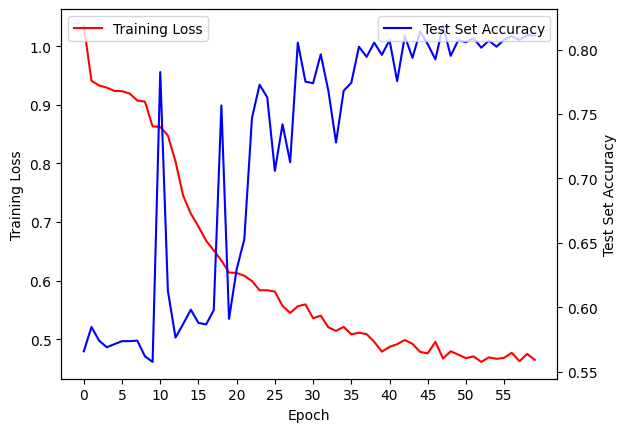

In [266]:
# plot training loss and test accuracy, same graph but different y-axis, give them different colors and y axis labels. Make x axis integer

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
training_losses = torch.tensor(training_losses).cpu()
test_accuracy = torch.tensor(test_accuracy).cpu()
ax1.plot(training_losses, label="Training Loss", color="red")
ax2.plot(test_accuracy, label="Test Set Accuracy", color="blue")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_ylabel("Training Loss")
ax2.set_ylabel("Test Set Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_xticks([i *5 for i in range(len(training_losses) // 5)])
plt.show()


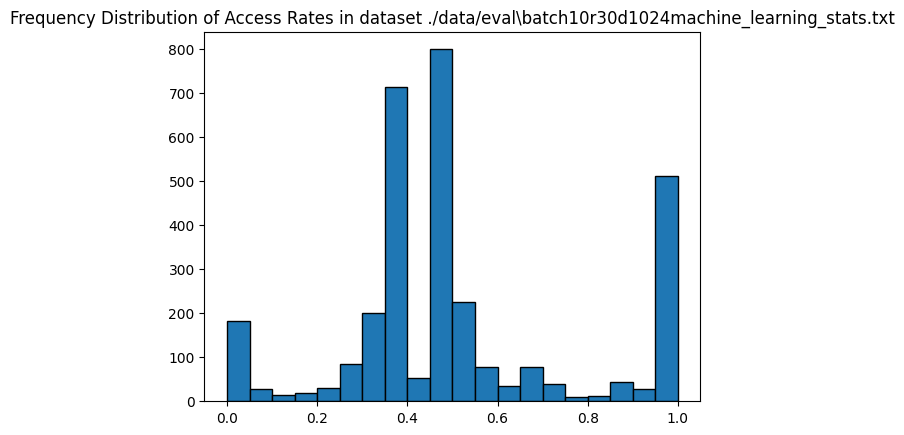

Test Error: 
 Avg difference: 0.3170, Avg loss: 1.110201, Accuracy: 0.4940 (1577/3192) 



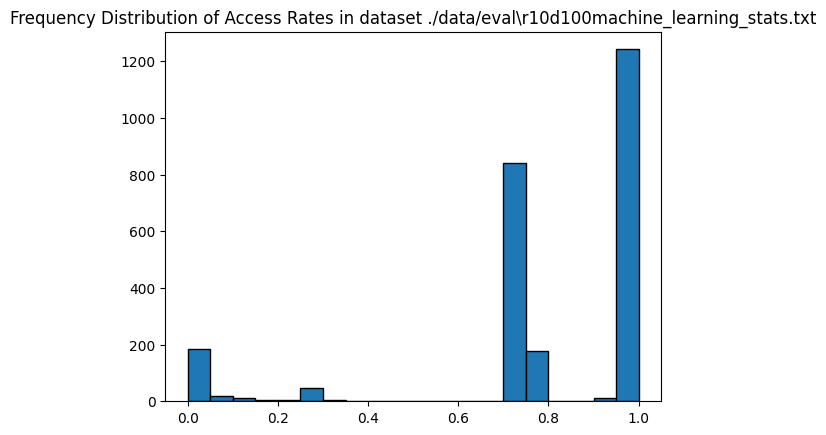

Test Error: 
 Avg difference: 0.2056, Avg loss: 0.551413, Accuracy: 0.8178 (2087/2552) 



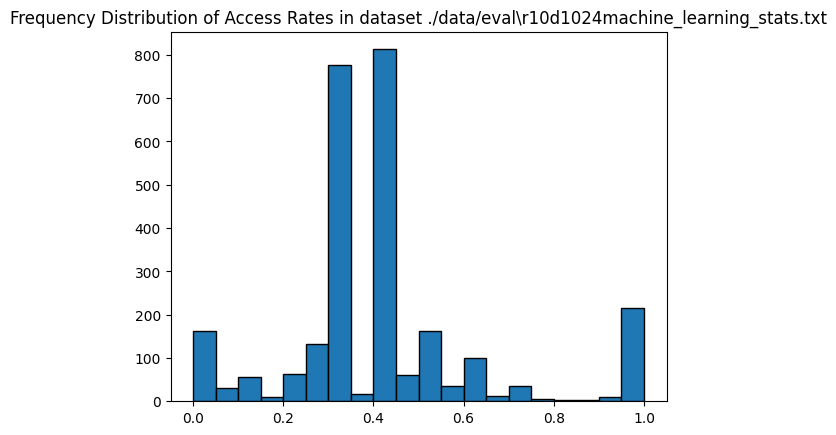

Test Error: 
 Avg difference: 0.3269, Avg loss: 1.148125, Accuracy: 0.4627 (1253/2708) 



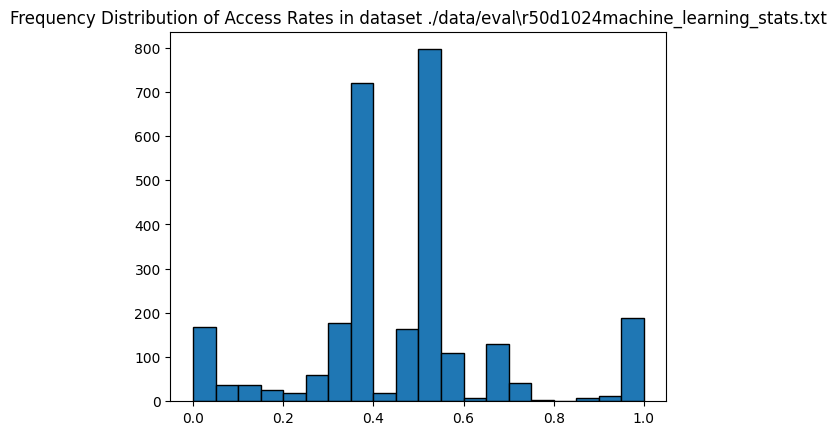

Test Error: 
 Avg difference: 0.3348, Avg loss: 1.200000, Accuracy: 0.4532 (1231/2716) 



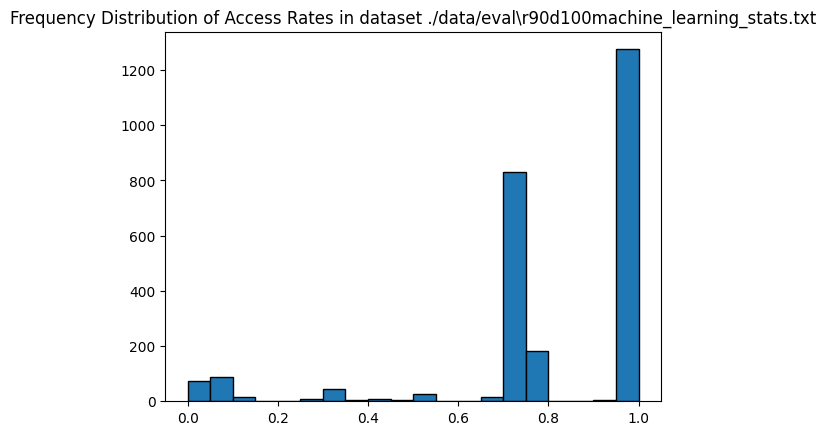

Test Error: 
 Avg difference: 0.2061, Avg loss: 0.526164, Accuracy: 0.8165 (2105/2578) 



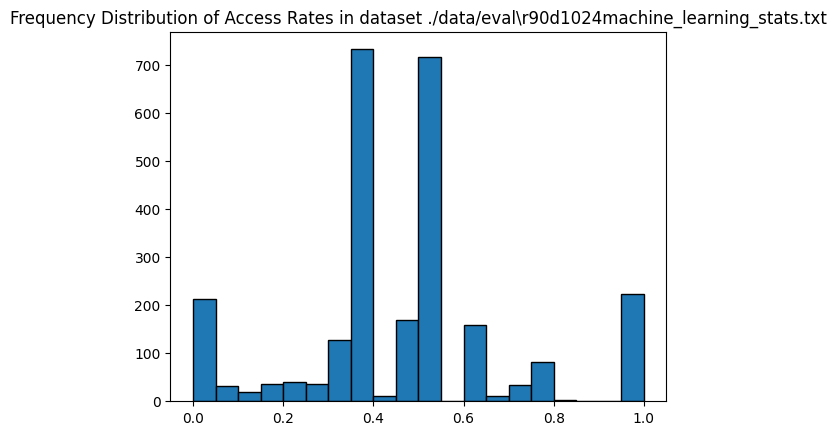

Test Error: 
 Avg difference: 0.3238, Avg loss: 1.162974, Accuracy: 0.4677 (1237/2645) 

{'batch10r30d1024': 0.49404761904761907, 'r10d100': 0.8177899686520376, 'r10d1024': 0.46270310192023634, 'r50d1024': 0.453240058910162, 'r90d100': 0.8165244375484872, 'r90d1024': 0.4676748582230624}


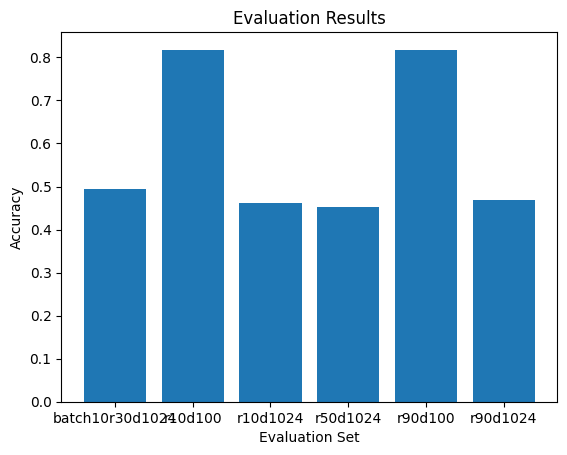

In [267]:
# model testing 
import os
from torch.utils.data import DataLoader

eval_results = {}
eval_dir = './data/eval'
for fname in os.listdir(eval_dir):
    if fname.endswith('.txt'):
        eval_path = os.path.join(eval_dir, fname)
        # You may need to replace this dataset logic if defined elsewhere:
        eval_dataset = MemoryHotnessDataset(eval_path, False)
        eval_loader = DataLoader(eval_dataset, batch_size=batch_size, collate_fn=collate_fn)
        acc = test(eval_loader, model, loss)
        dictName = fname.split("machine")[0]
        eval_results[dictName] = acc

print(eval_results)

# plot eval results
plt.bar(eval_results.keys(), eval_results.values())
plt.xlabel("Evaluation Set")
plt.ylabel("Accuracy")
plt.title("Evaluation Results")
plt.show()
